In [1]:
import numpy as np
import matplotlib.pyplot as plt
from single_photons.simulation.simulation_cavity import simulation_c
from control import dare
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.environment import Cavity_Particle

In [2]:
omega = 2*np.pi*1e5
T = 2*np.pi/omega
t = np.arange(0, 1000*T, T/400)
N = t.shape[0]
p = 1e-6
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
waist = 0.6e-6
eta_detection = 1
delta_t = 1e-9
control_step = 30 
fs = 1/(control_step*delta_t)
cavity_waist = 100e-6
cavity_length = 50e-3
tweezer_waist = 0.6e-6
detuning_ratio = 0.25 
cavity_linewidth_ratio = 0.5
optomechanical_coupling_ratio = 2.5

gamma, omega, ba_force, std_detection, std_z, g_cs, detuning, cavity_linewidth =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection, 
                                     cavity_length, cavity_waist, detuning_ratio, cavity_linewidth_ratio)

coupling = (1/(4*np.pi))*(ba_force**2)
g_0 = 0.19*omega
env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    optomechanical_coupling_ratio*g_0,
    coupling,
    radius=radius,
    eta_detection=eta_detection,
    T=T
)
variance_process = env.thermal_force_std**2 + env.backaction_std**2
std_detection = std_detection/env.zp_x
period = 2*np.pi/omega
t = np.arange(0, 5 * period, delta_t)
N = t.shape[0]

In [3]:
env.__omega_p__

501266.40589032974

In [4]:
pulse_amplitude = 6
pulse_center = 5000+int(1*t.shape[0]/2)
round_trip_time = 2*cavity_length/ct.c
#https://www.rp-photonics.com/q_factor.html inverse of loss gives the average amount of round trips
trips = 1/(2*np.pi*round_trip_time*cavity_linewidth_ratio*omega)
pulse_width = trips*round_trip_time/delta_t
alpha_in = pulse_amplitude/(np.sqrt(delta_t) * np.power(np.pi*pulse_width**2,1/4)) * (
    np.exp(-((np.arange(0, N, 1) - pulse_center) ** 2) / (2 * pulse_width**2))
)

NameError: name 'ct' is not defined

In [5]:
plt.plot(t, alpha_in)
plt.show()
pulse_width
s=0
for el in alpha_in:
    s = s+el**2*delta_t
print(pulse_width)
print(s)

NameError: name 'alpha_in' is not defined

In [6]:
def compute_optical_input(alpha_in, env, delta_t, N):
    x_in = (
    np.sqrt(env.__kappa__)
    * delta_t
    * (
        env.__optical_noise__ * np.random.normal() / np.sqrt(delta_t)
        + np.conjugate(alpha_in)
        + alpha_in
    )
    )
    y_in = (
        1j
        * np.sqrt(env.__kappa__)
        * delta_t
        * (
            env.__optical_noise__ * np.random.normal() / np.sqrt(delta_t)
            + np.conjugate(alpha_in)
            - alpha_in
        )
    )
    optical_input = 1j*np.zeros((4, N))
    optical_input[0, :] = x_in
    optical_input[1, :] = y_in    
    return optical_input
optical_input = compute_optical_input(alpha_in, env, delta_t, N)

NameError: name 'alpha_in' is not defined

In [7]:
Q = np.array(
    [
        [(env.__optical_noise__**2)*cavity_linewidth, 0, 0, 0],
        [0, (env.__optical_noise__**2)*cavity_linewidth, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process],
    ]
)*control_step*delta_t/2
R = np.array([[np.power(std_detection, 2)]])

In [8]:
g_fb = 5*omega
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omega/2, 0, 0, 0],
                        [0, omega/2, 0, 0],
                        [0, 0, omega/2, 0],
                        [0, 0, 0, omega/2]
                       ])
X, L, G_fb = dare(Ad, Bd, cost_states, omega/(g_fb**2))

In [9]:
env.backaction_std

713.9651244683361

In [10]:
x0 = 0
P0 = 1
new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
    env.A,
    env.B, 
    optical_input,
    env.thermal_force_std,
    env.backaction_std, 
    std_detection, 
    eta_detection,
    x0, 
    P0, 
    Ad, 
    Bd, 
    env.C, 
    env.G,
    G_fb,
    Q, 
    R, 
    delta_t, 
    control_step, 
    N
)

/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


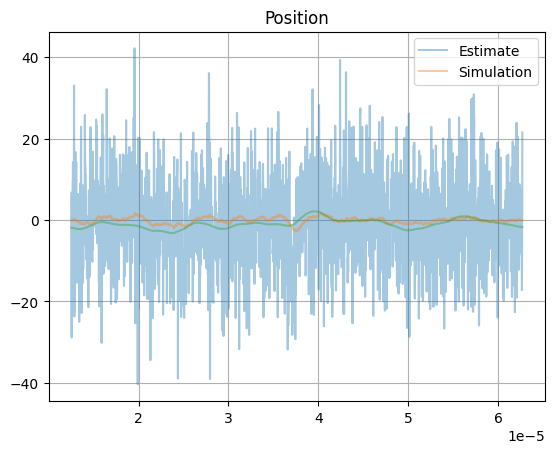

In [13]:
plt.close("all")
fig1 = plt.Figure()
plt.title("Position")
plt.plot(t[int(1/5*t.shape[0]):], measured_states[int(1/5*t.shape[0]):], alpha = 0.4)
plt.plot(t[int(1/5*t.shape[0]):], estimated_states[int(1/5*t.shape[0]):, 2], alpha = 0.4)
plt.plot(t[int(1/5*t.shape[0]):], new_states[int(1/5*t.shape[0]):, 2],alpha = 0.4)
#plt.plot(t[int(1/5*t.shape[0]):], new_states[int(1/5*t.shape[0]):, 3],alpha = 0.4)
#plt.plot(2*[pulse_center*np.diff(t)[0]], [min(estimated_states[int(1/5*t.shape[0]):, 2]),max(estimated_states[int(1/5*t.shape[0]):, 2])],alpha = 0.3,color = 'red')
C = max(controls[int(1/5*t.shape[0]):])/max(measured_states[int(1/5*t.shape[0]):])
controls = [x/C for x in controls]
#plt.plot(t[int(1/5*t.shape[0]):], controls[int(1/5*t.shape[0]):], alpha = 0.3,color = 'black')
plt.grid()
plt.legend(["Estimate", "Simulation"],loc = 'upper right')
plt.show()

In [1]:
plt.close("all")
fig1 = plt.Figure()
plt.title("Position")
#plt.plot(t[int(1/5*t.shape[0]):], measured_states[int(1/5*t.shape[0]):], alpha = 0.4)
plt.plot(t[int(1/5*t.shape[0]):], estimated_states[int(1/5*t.shape[0]):, 2], alpha = 0.4)
plt.plot(t[int(1/5*t.shape[0]):], new_states[int(1/5*t.shape[0]):, 2],alpha = 0.4)
#plt.plot(t[int(1/5*t.shape[0]):], new_states[int(1/5*t.shape[0]):, 3],alpha = 0.4)
#plt.plot(2*[pulse_center*np.diff(t)[0]], [min(estimated_states[int(1/5*t.shape[0]):, 2]),max(estimated_states[int(1/5*t.shape[0]):, 2])],alpha = 0.3,color = 'red')
C = max(controls[int(1/5*t.shape[0]):])/max(measured_states[int(1/5*t.shape[0]):])
controls = [x/C for x in controls]
#plt.plot(t[int(1/5*t.shape[0]):], controls[int(1/5*t.shape[0]):], alpha = 0.3,color = 'black')
plt.grid()
plt.legend(["Estimate", "Simulation"],loc = 'upper right')
plt.show()

NameError: name 'plt' is not defined

In [24]:
#plt.close("all")
#fig1 = plt.Figure()
#plt.title("Velocity")
#plt.plot(t[1:], estimated_states[1:, 3], alpha = 0.95)
#plt.plot(t[1:], new_states[1:, 3],alpha = 0.95)
#plt.grid()
#plt.legend(["Estimated", "Simulated"])
#plt.show()

In [25]:
#plt.figure()
#fig2 = plt.Figure()
#plt.title('X quadrature')
#plt.plot(t[int(1/5*t.shape[0]):], estimated_states[int(1/5*t.shape[0]):,0])
#plt.plot(t[int(1/5*t.shape[0]):], new_states[int(1/5*t.shape[0]):,0])
#plt.grid()
#plt.legend(['Estimated','Simulated'])
#plt.show()

In [26]:

# In[63]:
#fig2 = plt.Figure()
#plt.figure()
#plt.title("Photon number")
#plt.plot(
#    t[1:], np.power(estimated_states[1:, 0], 2) + np.power(estimated_states[1:, 1], 2)
#)
#plt.plot(t[1:], np.power(new_states[1:, 0], 2) + np.power(new_states[1:, 1], 2))
#plt.grid()
#plt.legend(["Estimated", "Simulated"])
#plt.show()


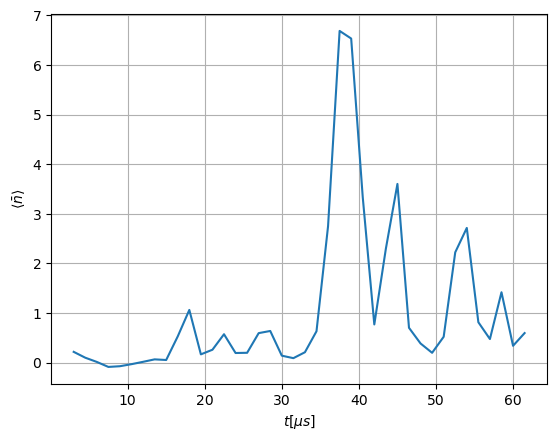

In [83]:
step=50
start = 1
phonons = compute_phonons(estimated_states[::control_step, :], kalman.error_covariance_aposteriori, step=step)
plt.plot(t[::control_step][::step][start+1:]/1e-6, phonons[start:])
#plt.plot(2*[pulse_center*np.diff(t)[0]/1e-6], [min(phonons[start:]),max(phonons[start:])],alpha = 0.2,color = 'green')
plt.ylabel(r'$\langle \bar{n} \rangle$')
plt.xlabel(r'$t[\mu s]$')
plt.grid()
plt.show()

4.834259234674931


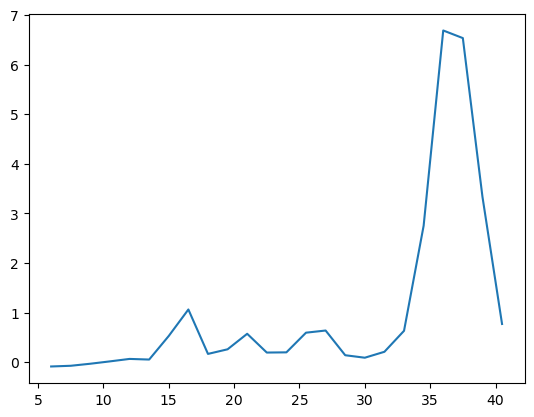

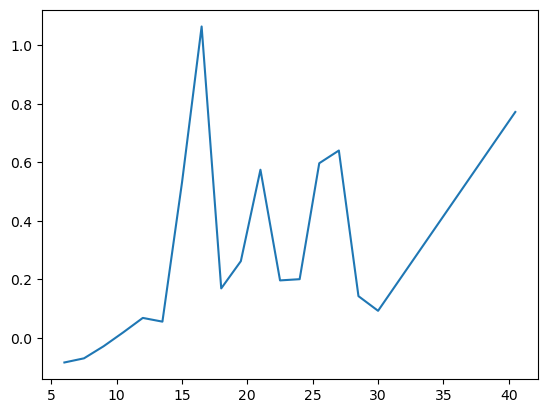

In [94]:
left = int((pulse_center-40*pulse_width)/(control_step*step))
right = int((pulse_center+15*pulse_width)/(control_step*step))
t_sample = t[::control_step][::step][left:right]
signal_sample = phonons[left:right]
if len(t_sample) > len(signal_sample):
    t_sample = t_sample[1:]
'''elif len(t_sample) < len(signal_sample):
    signal_sample = signal_sample[1:]'''
max_idx = np.where(signal_sample == max(signal_sample))[0][0]
signal_crop = np.append(signal_sample[:max_idx - int(8*pulse_width/(control_step*step))],\
                          signal_sample[max_idx + int(8*pulse_width/(control_step*step)):])
t_crop = np.append(t_sample[:max_idx - int(8*pulse_width/(control_step*step))],\
                          t_sample[max_idx + int(8*pulse_width/(control_step*step)):])

plt.figure()
plt.plot(t_sample/1e-6,signal_sample)
plt.figure()
plt.plot(t_crop/1e-6,signal_crop)

SNR = max(signal_sample)/(max(signal_crop) + np.std(signal_crop))
print(SNR)

In [19]:
print(kalman.error_covariance_apriori[-1], omega, g_cs, std_detection)

[[ 0.73500419  1.00990227 -0.52135936 -0.19066767]
 [ 1.00990227  1.93655015 -1.09902956  0.09322622]
 [-0.52135936 -1.09902956  1.27061144  0.40843908]
 [-0.19066767  0.09322622  0.40843908  1.03757578]] 501266.40589032974 96952.75519415858 11.436084942324618
